## PyTorch

Pytorch is a framework for doing differentition, optimization, and in particular optimization of neural networks (therefore, sometimes just called a deep learning framework) using the native imperative language style of Python.

### Some optional information about Pytorch and how it differs from its competitors

Most deep learning frameworks like TensorFlow and Theanos work with symbolic differentian and therefore it is necessary to declare the model structure before actually supplying any data and then ask the framework to compile the model (having the gradients calculated symbolically), after which point, the model will be good to go as long it does not change.

While those have advantages like possible algebraic simplifications when working out the derivates, they also come at some price: they impose a necessary "recompilation" of the model if it changes, they make code less intuitive to writting and more difficult to debug, are potentially more restrictive on model characteristics.

On the other hand, the framework of choice for this section, called PyTorch works with reverse-mode automatic differentiation which consists of creating the chain of differentiation (on a "tape") on-the-fly. That is, after the last operation is done (in our case, that's the calculation of the loss), the chain of operations is back-propagated (i.e.: running the "tape" backwards) and the gradients of the parameters of interest are calculated using chain rule.

Frameworks which works using symbolic differention are often called static while the ones that use automatic differentiation are called dynamic. Regardless of this, most (if not all) of those deep learning framework have two common characteristic that are worth emphasizing: they allow one to use its differentiation facilities to work with problems other than deep learning, neural networks or optimization (e.g.: Markov Chain Monte Carlo and Bayesian inference) and they natively support GPU acceleration (generally, using Nvidia CUDA).

The reason GPU acceleration is a common denominator over the deep learning frameworks is due to the fact that neural networks are strongly parallelizable problems and this make them well suited for GPU acceleration. This thus explain, at least in part, their recent surge in popularity given the scalability properties of such methods to big datasets, which on the other hand, are getting increasingly common and important.

### Now getting started

First of all, let's start by importing some basic stuff

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import random_split, TensorDataset, DataLoader
import pickle

%matplotlib inline

### Tensors and GPU

Now, let me present you with the basic storage type of Pytorch: the tensors. They work in very similar fashion to the numpy arrays.

In [2]:
x = torch.tensor([.45, .53])
y = x**2
y[0] = .3

a = torch.ones((2,4))
a = a * 2
a = a + 1
a[0,0] = .4

b = torch.zeros((4,2))
b = (b + 3) / 2
b[0,1] = .2

bt = b.transpose(0,1) # transpose

a + bt

torch.mm(a,b) # matrix multiplication

tensor([[14.1000, 13.5800],
        [18.0000, 14.1000]])

But Pytoch tensors have a special caveat: they can live on the GPU (if you have one proper installed... if you don't, then chances are that your computer might explode if you try to run this)!

In [3]:
a = torch.rand((3, 5)) # some random numbers
if torch.cuda.is_available():
    a = a.cuda()

b = torch.ones((5, 3))
if torch.cuda.is_available():
    b = b.cuda()
b = (b + 3) / 2
b[0,1] = .2

torch.mm(a, b) # matrix multiplication

tensor([[4.5492, 3.3939, 4.5492],
        [4.3107, 2.7360, 4.3107],
        [6.2844, 6.2774, 6.2844]], device='cuda:0')

### Float data type

Note that the default data type of Pytorch floats is 32 bit precision type: 

In [4]:
torch.rand((3, 5)).dtype

torch.float32

While on numpy the default is 64 bit precision type:

In [5]:
np.arange(4).dtype

dtype('int64')

You can pass a custom data type ``dtype`` function parameter or with special constructors:

In [6]:
print(torch.rand((3, 5), dtype=torch.float64).dtype)
print(torch.FloatTensor([.5]).dtype)
print(torch.HalfTensor([.5]).dtype)
print(torch.DoubleTensor([.5]).dtype)

torch.float64
torch.float32
torch.float16
torch.float64


But it's recommended to use the default float32 for most deep learning applications due to the speed up that it can give on vectorized operations, specially on GPUs.

### Differentiation

We can use Pytorch to do numerical differention using the code below:

In [7]:
x = torch.tensor([.45], requires_grad=True)
y = x**2
y.backward()
x.grad

tensor([0.9000])

``x.grad`` gives us the gradient of ``y`` with respect to ``x``. Now pay attetion at (and play with) this other example:

In [8]:
x = torch.tensor([.5,.3,.6], requires_grad=True)
y = x**2
z = y.sum()
z.backward()
x.grad

tensor([1.0000, 0.6000, 1.2000])

### Optimization

Now let's try using this integration framework for optimization:

In [9]:
x = torch.tensor([.45], requires_grad=True)

# "declares" that x is the variable being optimized by the Adam optimization algorith
optimizer = optim.Adam([x])

y = 2 * x**2 - 7 * x
y.backward() # "declares" that y is value being minimized

optimizer.step() # i.e. find the x that minimizes y
x

tensor([0.4510], requires_grad=True)

Here ``optimizer.step()`` moved ``x`` in the direction of its gradient; i.e. it moved ``x`` in the direction of that minimizes ``y``.

(Note that ``requires_grad=True`` is necessary in order to Pytorch to now that it must keep track of the operations done with ``x`` to backpropagate it back in the future to get the gradient of ``x``, it requires you to do so manually because otherwise it could save computational resources by not creating this structures).

However, this is just a little step towards optimization, we must repeat this many time to get there:

In [10]:
x = torch.tensor([-2.45], requires_grad=True)

optimizer = optim.Adam([x], lr=0.05)
for _ in range(1000):
    optimizer.zero_grad()
    y = 2 * x**2 - 7 * x
    y.backward()
    optimizer.step()
    
print("Numerical optimization solution:", x)
print("Analytic optimization solution:", 7/4)

Numerical optimization solution: tensor([1.7500], requires_grad=True)
Analytic optimization solution: 1.75


Great, we did it! Now let's try something more difficult, given i.i.d. Gaussian samples, let's try to $\hat{\mu}$ such that it minimize the sum of the squared errors of those samples and $\hat{\mu}$. We know from Statistical theory that the analytical solutional for this is the sample average.

In [11]:
mu_hat = torch.tensor([0.1], requires_grad=True)
mu_true = 1.5
x = stats.norm.rvs(size=2000, loc=mu_true, scale=3, random_state=0)
x = torch.as_tensor(x, dtype=torch.float32)

optimizer = optim.Adam([mu_hat], lr=0.05)
criterion = nn.MSELoss()
for _ in range(1000):
    optimizer.zero_grad()
    loss = criterion(x, mu_hat)
    loss.backward()
    optimizer.step()
    
print("Numerical optimization solution:", mu_hat)
print("Analytic optimization solution:", x.mean())

Numerical optimization solution: tensor([1.4525], requires_grad=True)
Analytic optimization solution: tensor(1.4525)


/home/marco/miniforge3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


And voila! It worked again!

### Neural networks with Pytorch

Now probably the most expected part, your first neural network with Pytorch:

Starting optimization.
Loss 5.02 in epoch 50                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

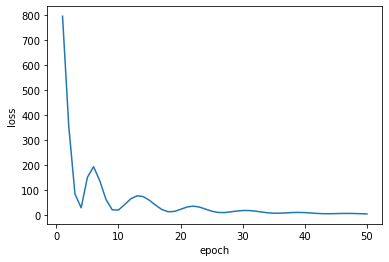

In [12]:
# Declares the structure of our neural network
class Net(nn.Module):
    def __init__(self):
        # this is strictly necessary!
        super(Net, self).__init__()
        
        # fully connected layer with input of size 10 and output of size 120
        self.fc1 = nn.Linear(90, 5000)
        
        # fully connected layer with input of size 10 and output of size 120
        self.fc2 = nn.Linear(5000, 1000)
        
        # fully connected layer with input of size 10 and output of size 120
        self.fc3 = nn.Linear(1000, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net1 = Net() # Construct the neural network object

# Creates some data using a linear regression of cosines
torch.manual_seed(1)
beta = torch.rand(90, 1)
train_inputv = torch.randn(700, 90)
train_target = torch.mm(torch.cos(train_inputv), beta)
train_target = train_target + torch.randn(700, 1) 

# If a GPU is available, move the network parameters and data into it
if torch.cuda.is_available():
    net1.cuda()
    train_inputv = train_inputv.cuda()
    train_target = train_target.cuda()
    
criterion = nn.MSELoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)

print("Starting optimization.")
losses = []
net1.train()
for epoch in range(50):
    optimizer.zero_grad()
    output = net1(train_inputv)
    loss = criterion(output, train_target)
    print('\r'+' '*1000, end='', flush=True)
    print('\rLoss', np.round(loss.item(), 2), 'in epoch', epoch + 1, end='', flush=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print("\nOptimization finished.")

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('epoch')
plt.ylabel('loss')

None

### Evaluation on test set

Now let's create more data from the same linear regression and see how well our network is able to predict it:

In [13]:
# Moves the network back to the CPU if it was on a GPU.
net1.cpu()

# Since we are not training the network anymore, let's put in
# evaluation mode which is faster. In case you need to train it
# again, call net1.train()
net1.eval()

# Creates some data using a linear regression
torch.manual_seed(2)
test_inputv = torch.randn(200, 90)
test_target = torch.mm(torch.cos(test_inputv), beta)
test_target = test_target + torch.randn(200, 1) 

with torch.no_grad():
    predicted_values = net1(test_inputv)
    loss_on_test = criterion(predicted_values, test_target).item()

print(f"loss on test dataset: {loss_on_test}")

loss on test dataset: 23.99188995361328


Exercise: try decreasing and increasing the amount of training data and see if this error goes down! Also try to change the number of features to see how it affects the error.

### TPUs

In addition to GPUs, it's possible to train PyTorch models using Google TPUs (which are available for free on Google Colab) the code below will automatically detect if a TPU is available in the current enviroment and proceed with installing the required depedencies if available.

For more information about using PyTorch with TPUs, visit: http://pytorch.org/xla/release/1.8/index.html

In [14]:
import os
import subprocess
if os.environ.get('COLAB_TPU_ADDR') is not None:
    # os.environ['XLA_USE_BF16'] = '1'
    pip_cmd = 'pip install cloud-tpu-client==0.10 '
    pip_cmd += 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl'
    subprocess.run(pip_cmd, shell=True, capture_output=True, check=True)
    import torch_xla
    import torch_xla.core.xla_model as xm

### Batch training

There seems to be some overfitting here, let's work that out by applying batch training:

In [15]:
if os.environ.get('COLAB_TPU_ADDR') is not None:
    device = xm.xla_device()
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

net1.to(device)
train_inputv = train_inputv.cpu()
train_target = train_target.cpu()
    
criterion = nn.MSELoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)

print("Starting optimization.")
losses = []
net1.train()
for epoch in range(300):
    pytorch_dataset = TensorDataset(train_inputv, train_target)
    dataset_loader = DataLoader(
           pytorch_dataset, batch_size=100, shuffle=True,
           pin_memory=device.type=='cuda', drop_last=True
    )
    batch_losses = []
    for batch_inputv, batch_target in dataset_loader:
        batch_inputv = batch_inputv.to(device)
        batch_target = batch_target.to(device)
            
        optimizer.zero_grad()
        output = net1(batch_inputv)
        batch_loss = criterion(output, batch_target)

        batch_loss.backward()
        optimizer.step()
        batch_losses.append(batch_loss.item())
    loss = np.mean(batch_losses)
    losses.append(loss)
    if not (epoch+1) % 25:
        print('\r'+' '*1000, end='', flush=True)
        print('\rLoss', np.round(loss.item(), 2), 'in epoch', epoch + 1, end='', flush=True)
        
print("\nOptimization finished.")

# Evaluation on test set
net1.cpu()
net1.eval()
with torch.no_grad():
    predicted_values = net1(test_inputv)
    loss_on_test = criterion(predicted_values, test_target).item()
print(f"Loss on test dataset: {loss_on_test}")

Starting optimization.
Loss 0.05 in epoch 300                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### Dropout, batch normalization and ELU activation

That's an improvement, but but there still seems to be a lot of overfitting, let's work that out by applying dropout, batch normalization and using ELU activation:

In [16]:
# Declares the structure of our neural network
class Net(nn.Module):
    def __init__(self):
        # this is strictly necessary!
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(90, 5000),
            nn.ELU(),
            nn.BatchNorm1d(5000),
            nn.Dropout(),

            nn.Linear(5000, 1000),
            nn.ELU(),
            nn.BatchNorm1d(1000),
            nn.Dropout(),

            nn.Linear(1000, 1),
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

net2 = Net() # Construct the neural network object

In [17]:
if os.environ.get('COLAB_TPU_ADDR') is not None:
    device = xm.xla_device()
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
net2.to(device)
train_inputv = train_inputv.cpu()
train_target = train_target.cpu()

criterion = nn.MSELoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)

print("Starting optimization.")
losses = []
net2.train()
for epoch in range(300):
    pytorch_dataset = TensorDataset(train_inputv, train_target)
    dataset_loader = DataLoader(
           pytorch_dataset, batch_size=100, shuffle=True,
           pin_memory=device.type=='cuda', drop_last=True
    )
    batch_losses = []
    for batch_inputv, batch_target in dataset_loader:
        batch_inputv = batch_inputv.to(device)
        batch_target = batch_target.to(device)
            
        optimizer.zero_grad()
        output = net2(batch_inputv)
        batch_loss = criterion(output, batch_target)

        batch_loss.backward()
        optimizer.step()
        batch_losses.append(batch_loss.item())
    loss = np.mean(batch_losses)
    losses.append(loss)
    if not (epoch+1) % 25:
        print('\r'+' '*1000, end='', flush=True)
        print('\rLoss', np.round(loss.item(), 2), 'in epoch', epoch + 1, end='', flush=True)
        
        
print("\nOptimization finished.")

# Evaluation on test set
net2.cpu()
net2.eval()
with torch.no_grad():
    predicted_values = net2(test_inputv)
    loss_on_test = criterion(predicted_values, test_target).item()
print(f"Loss on test dataset: {loss_on_test}")

Starting optimization.
Loss 4.24 in epoch 300                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### Early stopping

It's even better now! So let's create an early stopping system to choose the number of epochs to stop training.

In [18]:
if os.environ.get('COLAB_TPU_ADDR') is not None:
    device = xm.xla_device()
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
net2.to(device)
train_inputv = train_inputv.cpu()
train_target = train_target.cpu()

criterion = nn.MSELoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)

print("Starting optimization.")
train_losses = []
val_losses = []

# db split
val_idx = np.random.choice(len(train_inputv), len(train_inputv)//10, False)
train_idx = [x for x in range(len(train_inputv)) if x not in val_idx]
val_inputv = train_inputv[val_idx]
val_target = train_target[val_idx]
subtrain_inputv = train_inputv[train_idx]
subtrain_target = train_target[train_idx]

# initial values for early stopping decision state parameters
last_val_loss = np.inf
es_tries = 0

for epoch in range(100_000):
    
    # network training step 
    net2.train()    
    pytorch_dataset_train = TensorDataset(subtrain_inputv, subtrain_target)
    dataset_loader_train = DataLoader(
           pytorch_dataset_train, batch_size=100, shuffle=True,
           pin_memory=device.type=='cuda', drop_last=True
    )
    batch_losses = []
    for batch_inputv, batch_target in dataset_loader_train:
        batch_inputv = batch_inputv.to(device)
        batch_target = batch_target.to(device)
            
        optimizer.zero_grad()
        output = net2(batch_inputv)
        batch_loss = criterion(output, batch_target)

        batch_loss.backward()
        optimizer.step()
        batch_losses.append(batch_loss.item())
    loss = np.mean(batch_losses)
    train_losses.append(loss)
    if not (epoch+1) % 25:
        print('\r'+' '*1000, end='', flush=True)
        print('\rTrain loss', np.round(loss.item(), 2), end='')    

    # network evaluation step 
    net2.eval()
    with torch.no_grad():
        pytorch_dataset_val = TensorDataset(val_inputv, val_target)
        dataset_loader_val = DataLoader(
               pytorch_dataset_val, batch_size=100, shuffle=False,
               pin_memory=device.type=='cuda', drop_last=False,
        )
        batch_losses = []
        batch_sizes = []
        for batch_inputv, batch_target in dataset_loader_val:
            batch_inputv = batch_inputv.to(device)
            batch_target = batch_target.to(device)

            output = net2(batch_inputv)
            batch_loss = criterion(output, batch_target)

            batch_losses.append(batch_loss.item())
            batch_sizes.append(len(batch_inputv))
        loss = np.average(batch_losses, weights=batch_sizes)
        val_losses.append(loss)
        
        if not (epoch+1) % 25:
            print(' | Validation loss', np.round(loss.item(), 2), 'in epoch', epoch + 1, end='')
        
        # Decisions based on the evaluated values
        if loss < last_val_loss:
            best_state_dict = net2.state_dict()
            best_state_dict = pickle.dumps(best_state_dict)
            es_tries = 0
            last_val_loss = loss
        else:
            if es_tries in [20, 40]:
                net2.load_state_dict(pickle.loads(best_state_dict))
            
            if es_tries >= 60:
                net2.load_state_dict(pickle.loads(best_state_dict))
                break
                
            es_tries += 1    
        if not (epoch+1) % 25:
            print(' | es_tries', es_tries, end='', flush=True)

print(f"\nOptimization finished in {epoch+1} epochs.")

# Evaluation on test set
net2.cpu()
net2.eval()
with torch.no_grad():
    predicted_values = net2(test_inputv)
    loss_on_test = criterion(predicted_values, test_target).item()
print(f"Loss on test dataset: {loss_on_test}")

Starting optimization.
Train loss 4.69 | Validation loss 1.32 in epoch 75 | es_tries 51                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Text(0, 0.5, 'loss')

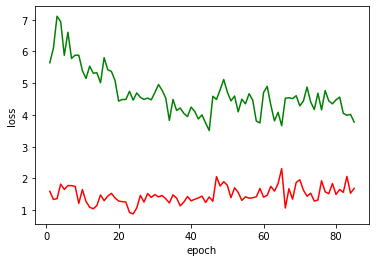

In [19]:
plt.plot(range(1, len(train_losses)+1), train_losses, color='green')
plt.plot(range(1, len(train_losses)+1), val_losses, color='red')
plt.xlabel('epoch')
plt.ylabel('loss')

### Classification

In [20]:
# Declares the structure of our neural network
class Net(nn.Module):
    def __init__(self):
        # this is strictly necessary!
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(90, 5000),
            nn.ELU(),
            nn.BatchNorm1d(5000),
            nn.Dropout(),

            nn.Linear(5000, 1000),
            nn.ELU(),
            nn.BatchNorm1d(1000),
            nn.Dropout(),

            nn.Linear(1000, 4),
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

net3 = Net() # Construct the neural network object

In [21]:
if os.environ.get('COLAB_TPU_ADDR') is not None:
    device = xm.xla_device()
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# transform target into integers labels
train_target_label = train_target - torch.floor(train_target)
train_target_label = torch.round(train_target_label * 3)
train_target_label = torch.as_tensor(train_target_label, dtype=torch.long).flatten()

test_target_label = test_target - torch.floor(test_target)
test_target_label = torch.round(test_target_label * 3)
test_target_label = torch.as_tensor(test_target_label, dtype=torch.long).flatten()

net3.to(device)
train_inputv = train_inputv.cpu()
train_target_label = train_target_label.cpu()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001)

print("Starting optimization.")
train_losses = []
val_losses = []

# db split
val_idx = np.random.choice(len(train_inputv), len(train_inputv)//10, False)
train_idx = [x for x in range(len(train_inputv)) if x not in val_idx]
val_inputv = train_inputv[val_idx]
val_target_label = train_target_label[val_idx]
subtrain_inputv = train_inputv[train_idx]
subtrain_target_label = train_target_label[train_idx]

# initial values for early stopping decision state parameters
last_val_loss = np.inf
es_tries = 0

for epoch in range(100_000):
    
    # network training step 
    net3.train()    
    pytorch_dataset_train = TensorDataset(subtrain_inputv, subtrain_target_label)
    dataset_loader_train = DataLoader(
           pytorch_dataset_train, batch_size=100, shuffle=True,
           pin_memory=device.type=='cuda', drop_last=True
    )
    batch_losses = []
    for batch_inputv, batch_target_label in dataset_loader_train:
        batch_inputv = batch_inputv.to(device)
        batch_target_label = batch_target_label.to(device)
            
        optimizer.zero_grad()
        output = net3(batch_inputv)
        batch_loss = criterion(output, batch_target_label)

        batch_loss.backward()
        optimizer.step()
        batch_losses.append(batch_loss.item())
    loss = np.mean(batch_losses)
    train_losses.append(loss)
    if not (epoch+1) % 25:
        print('\r'+' '*1000, end='', flush=True)
        print('\rTrain loss', np.round(loss.item(), 2), end='')    

    # network evaluation step 
    net3.eval()
    with torch.no_grad():
        pytorch_dataset_val = TensorDataset(val_inputv, val_target_label)
        dataset_loader_val = DataLoader(
               pytorch_dataset_val, batch_size=100, shuffle=False,
               pin_memory=device.type=='cuda', drop_last=False,
        )
        batch_losses = []
        batch_sizes = []
        for batch_inputv, batch_target_label in dataset_loader_val:
            batch_inputv = batch_inputv.to(device)
            batch_target_label = batch_target_label.to(device)

            optimizer.zero_grad()
            output = net3(batch_inputv)
            batch_loss = criterion(output, batch_target_label)

            batch_losses.append(batch_loss.item())
            batch_sizes.append(len(batch_inputv))
        loss = np.average(batch_losses, weights=batch_sizes)
        val_losses.append(loss)
        
        if not (epoch+1) % 25:
            print(' | Validation loss', np.round(loss.item(), 2), 'in epoch', epoch + 1, end='')
        
        # Decisions based on the evaluated values
        if loss < last_val_loss:
            best_state_dict = net3.state_dict()
            best_state_dict = pickle.dumps(best_state_dict)
            es_tries = 0
            last_val_loss = loss
        else:
            if es_tries in [20, 40]:
                net3.load_state_dict(pickle.loads(best_state_dict))
            
            if es_tries >= 60:
                net3.load_state_dict(pickle.loads(best_state_dict))
                break
                
            es_tries += 1    
        if not (epoch+1) % 25:
            print(' | es_tries', es_tries, end='', flush=True)

print(f"\nOptimization finished in {epoch+1} epochs.")

# Evaluation on test set
net3.cpu()
net3.eval()
with torch.no_grad():
    predicted_values = net3(test_inputv)
    loss_on_test = criterion(predicted_values, test_target_label).item()
print(f"Loss on test dataset: {loss_on_test}")

Starting optimization.
Train loss 0.21 | Validation loss 2.26 in epoch 100 | es_tries 52                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### Classification with network chosen by Data splitting

In [22]:
from sklearn.base import BaseEstimator
import hashlib

class CustomizableNet(nn.Module):
    def __init__(self, hsize1, hsize2, nfeatures):
        # this is strictly necessary!
        super().__init__()
        
        self.layers = nn.Sequential(
            self._initialize_layer(nn.Linear(nfeatures, hsize1)),
            nn.ELU(),
            nn.BatchNorm1d(hsize1),
            nn.Dropout(),

            self._initialize_layer(nn.Linear(hsize1, hsize2)),
            nn.ELU(),
            nn.BatchNorm1d(hsize2),
            nn.Dropout(),

            self._initialize_layer(nn.Linear(hsize2, 4)),
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x
    
    def _initialize_layer(self, layer):
        nn.init.constant_(layer.bias, 0)
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(layer.weight, gain=gain)
        return layer

class NeuralNetEstimator(BaseEstimator):
    def __init__(self, hsize1 = 5000, hsize2=1000, batch_size = 100, lr=0.001,
                 weight_decay=0, cache_dir=None):
        self.hsize1 = hsize1
        self.hsize2 = hsize2
        self.batch_size = 100
        self.lr = lr
        self.weight_decay = weight_decay
        self.cache_dir = cache_dir
    
    def fit(self, x_train, y_train):
        train_inputv = torch.as_tensor(x_train, dtype=torch.float32)
        train_target = torch.as_tensor(y_train, dtype=torch.long)
        
        self.net = CustomizableNet(self.hsize1, self.hsize2, train_inputv.shape[1])
        if os.environ.get('COLAB_TPU_ADDR') is not None:
            device = xm.xla_device()
        elif torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')

        self.net.to(device)
        
        train_inputv = train_inputv.cpu()
        train_target = train_target.cpu()

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        print("Starting optimization.")
        self.train_losses = []
        self.val_losses = []

        # db split
        train_idx = torch.randperm(len(train_inputv))
        val_idx = train_idx[:len(train_inputv)//10]
        train_idx = train_idx[len(train_inputv)//10:]
        
        val_inputv = train_inputv[val_idx]
        val_target = train_target[val_idx]
        subtrain_inputv = train_inputv[train_idx]
        subtrain_target = train_target[train_idx]


        # initial values for early stopping decision state parameters
        last_val_loss = np.inf
        es_tries = 0

        for epoch in range(100_000):
            try:
                # network training step 
                self.net.train()    
                pytorch_dataset_train = TensorDataset(subtrain_inputv, subtrain_target)
                dataset_loader_train = DataLoader(
                       pytorch_dataset_train, batch_size=self.batch_size, shuffle=True,
                       pin_memory=device.type=='cuda', drop_last=True
                )
                batch_losses = []
                for batch_inputv, batch_target in dataset_loader_train:
                    batch_inputv = batch_inputv.to(device)
                    batch_target = batch_target.to(device)

                    optimizer.zero_grad()
                    output = self.net(batch_inputv)
                    batch_loss = criterion(output, batch_target)

                    batch_loss.backward()
                    optimizer.step()
                    batch_losses.append(batch_loss.item())
                loss = np.mean(batch_losses)
                self.train_losses.append(loss)
                if not (epoch+1) % 5:
                    print('\r'+' '*1000, end='', flush=True)
                    print('\rTrain loss', np.round(loss.item(), 2), end='')    

                # network evaluation step 
                self.net.eval()
                with torch.no_grad():
                    pytorch_dataset_val = TensorDataset(val_inputv, val_target)
                    dataset_loader_val = DataLoader(
                           pytorch_dataset_val, batch_size=self.batch_size, shuffle=False,
                           pin_memory=device.type=='cuda', drop_last=False,
                    )
                    batch_losses = []
                    batch_sizes = []
                    for batch_inputv, batch_target in dataset_loader_val:
                        batch_inputv = batch_inputv.to(device)
                        batch_target = batch_target.to(device)

                        optimizer.zero_grad()
                        output = self.net(batch_inputv)
                        batch_loss = criterion(output, batch_target)

                        batch_losses.append(batch_loss.item())
                        batch_sizes.append(len(batch_inputv))
                    loss = np.average(batch_losses, weights=batch_sizes)
                    self.val_losses.append(loss)

                    if not (epoch+1) % 5:
                        print(' | Validation loss', np.round(loss.item(), 2), 'in epoch', epoch + 1, end='')

                    # Decisions based on the evaluated values
                    if loss < last_val_loss:
                        best_state_dict = self.net.state_dict()
                        best_state_dict = pickle.dumps(best_state_dict)
                        es_tries = 0
                        last_val_loss = loss
                    else:
                        if es_tries >= 10:
                            self.net.load_state_dict(pickle.loads(best_state_dict))
                            break

                        es_tries += 1    
                    if not (epoch+1) % 5:
                        print(' | es_tries', es_tries, end='', flush=True)
                        
            except KeyboardInterrupt:
                if epoch > 0:
                     print("\nKeyboard interrupt detected.",
                           "Switching weights to lowest validation loss",
                           "and exiting")
                     self.net.load_state_dict(pickle.loads(best_state_dict))
                break
                        
        print(f"\nOptimization finished in {epoch+1} epochs.")

    #def predict_proba(self, x_pred):
    
    #def predict(self, x_pred):
    
    def score(self, x_score, y_score):
        return - self.get_loss(x_score, y_score)[0]
        
    def get_loss(self, x_score, y_score):
        criterion = nn.CrossEntropyLoss()
        if os.environ.get('COLAB_TPU_ADDR') is not None:
            device = xm.xla_device()
        elif torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        
        score_inputv = torch.as_tensor(x_score, dtype=torch.float32)
        score_target = torch.as_tensor(y_score, dtype=torch.long)
        
        dataset = TensorDataset(score_inputv, score_target)
        dataset_loader_train = DataLoader(
            pytorch_dataset_train, batch_size=100, shuffle=True,
            pin_memory=device.type=='cuda', drop_last=True
        )
        self.net.eval()
        with torch.no_grad():
            dataset = DataLoader(
                  dataset, batch_size=100, shuffle=False,
                  pin_memory=device.type=='cuda', drop_last=False,
            )
            cv_batch_losses = []
            zo_batch_losses = []
            batch_sizes = []
            for batch_inputv, batch_target in dataset_loader_val:
                batch_inputv = batch_inputv.to(device)
                batch_target = batch_target.to(device)

                output = self.net(batch_inputv)
                cv_batch_loss = criterion(output, batch_target)
                zo_batch_loss = (torch.argmax(output, 1) != batch_target).cpu()
                zo_batch_loss = np.array(zo_batch_loss).mean()

                cv_batch_losses.append(cv_batch_loss.item())
                zo_batch_losses.append(zo_batch_loss.item())
                batch_sizes.append(len(batch_inputv))
            cv_loss = np.average(cv_batch_losses, weights=batch_sizes)
            zo_loss = np.average(zo_batch_losses, weights=batch_sizes)

            return cv_loss, zo_loss

nn_estimator = NeuralNetEstimator(hsize1 = 5000, hsize2=1000)
nn_estimator.fit(train_inputv, train_target_label)
loss_on_test = nn_estimator.get_loss(test_inputv, test_target_label)
print(f"Loss on test dataset for default parameters: {loss_on_test}")

Starting optimization.
Train loss 0.69 | Validation loss 3.05 in epoch 10 | es_tries 9                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [23]:
from sklearn.pipeline import Pipeline
import tempfile
import os
import time
tempdir = tempfile.TemporaryDirectory().name
os.mkdir(tempdir)
class CachedPipeline(Pipeline):
    def fit(self, x,y):
        super().fit(x,y)
        
        filename = self.get_filepath(self.get_params())
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

        return self
    
    def get_filepath(self, dict_):
        h = hashlib.new('ripemd160')
        dict_ = {k:v for k,v in dict_.items() if '__' in k}
        h.update(pickle.dumps(sorted(list(dict_.items()))))
        filename = h.hexdigest()
        return os.path.join(tempdir, filename)
    
    def reconstruct(self, params):
        all_params = self.get_params().copy()
        for k, v in params.items():
            all_params[k] = v
        filename = self.get_filepath(all_params)
        with open(filename, 'rb') as file:
            return pickle.load(file)

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler
import time

pl_estimator = CachedPipeline((
    ('scaler', StandardScaler()),
    ('nn', NeuralNetEstimator()),
))

gs_params = {
    'nn__hsize1': [500, 600, 1000, 2000, 3000, 5000, 7000, 8000, 10000],
    'nn__hsize2': [100, 500, 750, 1000, 2000, 4000, 6000],
    'nn__lr': np.logspace(-0.1, -5),
    'nn__weight_decay': np.logspace(-10, 1)-1e-10,
    'nn__batch_size': [100, 200],
}
cv = ShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
gs_estimator = RandomizedSearchCV(pl_estimator, gs_params, cv=cv, refit=False, n_iter=300)

start_time = time.time()
gs_estimator.fit(train_inputv, train_target_label)
end_time = time.time()
print(f"Fit process time: {end_time-start_time}")
print(f"Best parameters: {gs_estimator.best_params_}")

# reconstruct best estimator from disk cache
best_nn_estimator = gs_estimator.estimator.reconstruct(gs_estimator.best_params_)

loss_on_test = best_nn_estimator.steps[-1][1].get_loss(
    best_nn_estimator.steps[0][1].transform(test_inputv), test_target_label
)
print(f"Loss on test dataset for parameters found using Data splitting: {loss_on_test}")

Starting optimization.
Train loss 2.95 | Validation loss 1.76 in epoch 10 | es_tries 8                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  